In [327]:
import pandas as pd
import numpy as np

#ploting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from statistics import mode

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

#modeling
import xgboost as xgb

In [396]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

#drop outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

train_y = np.log1p(train['SalePrice'])
train.drop(['SalePrice'], axis=1, inplace=True)

train.drop(['Id'], axis=1, inplace=True)



test_id = test['Id']
test.drop(['Id'], axis=1, inplace=True)

df = pd.concat([train, test], axis= 0)

In [397]:
#data dimension
df.shape

(2917, 79)

In [398]:
#missing values
pd.DataFrame(df.isnull().sum()).reset_index().sort_values(by = 0, ascending=False).head(34)

,index,0
71,PoolQC,2908
73,MiscFeature,2812
5,Alley,2719
72,Fence,2346
56,FireplaceQu,1420
2,LotFrontage,486
58,GarageYrBlt,159
59,GarageFinish,159
62,GarageQual,159
63,GarageCond,159


In [399]:
#spliting object dataframe and numeric dataframe
df_num = df.select_dtypes(exclude= ['object'])
df_cat = df.select_dtypes(include=['object']).copy()

## Categorical Variables 

In [400]:
df_cat.shape

(2917, 43)

In [401]:
cat_missing = pd.DataFrame(df_cat.isnull().sum()).reset_index().sort_values(by = 0, ascending=False).head(34)

In [402]:
cat_missing_index = cat_missing.iloc[:,0]

In [335]:
for i in range(len(cat_missing_index)):
    if (cat_missing.iloc[:,1].values[i]) > 600:
        df_cat[cat_missing_index.values[i]] = df_cat[cat_missing_index.values[i]].fillna('none')
    else:
        df_cat[cat_missing_index.values[i]][df_cat[cat_missing_index.values[i]].isnull()] = mode(df_cat[cat_missing_index.values[i]])

## Numeric Variables

In [403]:
df_num.shape

(2917, 36)

In [404]:
pd.DataFrame(df_num.isnull().sum()).reset_index().sort_values(by = 0, ascending=False).head(20)

,index,0
1,LotFrontage,486
24,GarageYrBlt,159
7,MasVnrArea,23
17,BsmtHalfBath,2
16,BsmtFullBath,2
11,TotalBsmtSF,1
25,GarageCars,1
8,BsmtFinSF1,1
9,BsmtFinSF2,1
10,BsmtUnfSF,1


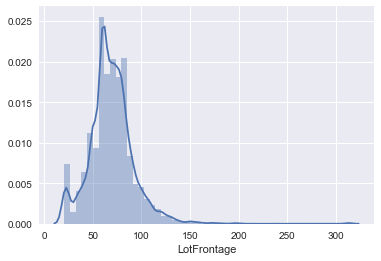

In [338]:
sns.distplot(df_num.LotFrontage[~np.isnan(df_num.LotFrontage)])

In [339]:
sns.distplot(df_num[df_num.LotFrontage.isnull()].SalePrice)
sns.distplot(df_num[~df_num.LotFrontage.isnull()].SalePrice)

AttributeError: 'DataFrame' object has no attribute 'SalePrice'

In [340]:
df_num.LotFrontage = df_num.LotFrontage.fillna(0)

C:\Users\Xi\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


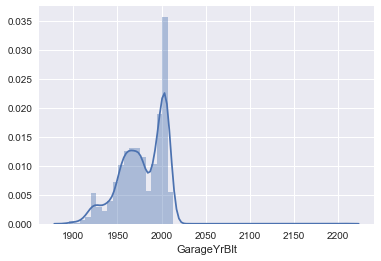

In [341]:
sns.distplot(df_num.GarageYrBlt[~np.isnan(df_num.GarageYrBlt)])

In [171]:
sns.regplot(x = df_num.GarageYrBlt[~np.isnan(df_num.GarageYrBlt)], y = df_num.SalePrice[~np.isnan(df_num.GarageYrBlt)])

AttributeError: 'DataFrame' object has no attribute 'SalePrice'

In [220]:
sns.distplot(df_num.SalePrice[~np.isnan(df_num.GarageYrBlt)])
sns.distplot(df_num.SalePrice[np.isnan(df_num.GarageYrBlt)])

AttributeError: 'DataFrame' object has no attribute 'SalePrice'

In [405]:
#we can use clustering to determine the built year, but for now we will just categorize the built year as 0
df_num.GarageYrBlt = df_num.GarageYrBlt.fillna(0)

C:\Users\Xi\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [406]:
df_num.MasVnrArea = df_num.MasVnrArea.fillna(10000)

C:\Users\Xi\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Factorize

In [223]:
#df_dict = df_cat.to_dict('records')

#dv = DictVectorizer(sparse=False)
#df_cat_encoded = dv.fit_transform(df_dict)

#df_cat_encoded = pd.DataFrame(df_cat_encoded, columns=dv.vocabulary_)

In [407]:
for i in df_cat:
    df_cat[i] = pd.factorize(df_cat[i])[0]

## 

In [408]:
df = pd.concat([df_num, df_cat], axis=1)
pos = train.shape[0]

train = df[:pos]
test = df[pos:]

In [125]:
#scaler = StandardScaler()
#df_num_scale = df_num.apply(lambda x: scaler.fit_transform(x))

## XGBoost

### Grid Search

In [410]:
gbm = xgb.XGBRegressor(nthread=4)

gbm_param_grid = {
    'learning_rate': np.arange(0, 0.5, 0.05),
    'gamma': np.arange(0.01, 1, 0.01),
    'max_depth': np.arange(2, 25, 1),
    'n_estimators': np.arange(15, 250, 50),
    "colsample_bytree": np.arange(0.01, 1, 0.1)
}

randomized_reg = RandomizedSearchCV(estimator=gbm, param_distributions= gbm_param_grid, n_iter=20, cv=10,
                                    scoring="neg_mean_squared_error", verbose = 20)

In [411]:
randomized_reg.fit(train, train_y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65 
[CV]  learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65, score=-0.036610501997921846, total=   0.0s
[CV] learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65, score=-0.02484842564733148, total=   0.0s
[CV] learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65 
[CV]  learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65, score=-0.0234580820099192, total=   0.0s
[CV] learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65, score=-0.036138353530481414, total=   0.0s
[CV] learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65 
[CV]  learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65, score=-0.04297214980270052, total=   0.0s
[CV] learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s


[CV]  learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65, score=-0.02321294721804981, total=   0.0s
[CV] learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65 
[CV]  learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65, score=-0.03285474978365923, total=   0.0s
[CV] learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s


[CV]  learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65, score=-0.026964006905629282, total=   0.0s
[CV] learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65 
[CV]  learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65, score=-0.030140905359952765, total=   0.0s
[CV] learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s remaining:    0.0s


[CV]  learning_rate=0.85, gamma=0.82, colsample_bytree=0.91, max_depth=6, n_estimators=65, score=-0.03758967789342204, total=   0.0s
[CV] learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215 
[CV]  learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215, score=-0.04203616880744297, total=   0.1s
[CV] learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215 


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.3s remaining:    0.0s


[CV]  learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215, score=-0.04615543215986269, total=   0.1s
[CV] learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215 


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.5s remaining:    0.0s


[CV]  learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215, score=-0.05523105376721691, total=   0.1s
[CV] learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215 


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


[CV]  learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215, score=-0.04180536415474734, total=   0.1s
[CV] learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215 


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.0s remaining:    0.0s


[CV]  learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215, score=-0.04326226966942817, total=   0.1s
[CV] learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215 


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.3s remaining:    0.0s


[CV]  learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215, score=-0.036153450856891, total=   0.1s
[CV] learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215 


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.5s remaining:    0.0s


[CV]  learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215, score=-0.033956163352917505, total=   0.1s
[CV] learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215 


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.8s remaining:    0.0s


[CV]  learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215, score=-0.047932347198833374, total=   0.1s
[CV] learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215 


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.0s remaining:    0.0s


[CV]  learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215, score=-0.03549376720787368, total=   0.1s
[CV] learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215 


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.2s remaining:    0.0s


[CV]  learning_rate=0.8, gamma=0.05, colsample_bytree=0.11, max_depth=14, n_estimators=215, score=-0.0366735764746189, total=   0.1s
[CV] learning_rate=0.05, gamma=0.4, colsample_bytree=0.61, max_depth=24, n_estimators=215 
[CV]  learning_rate=0.05, gamma=0.4, colsample_bytree=0.61, max_depth=24, n_estimators=215, score=-0.018637477669173907, total=   0.7s
[CV] learning_rate=0.05, gamma=0.4, colsample_bytree=0.61, max_depth=24, n_estimators=215 
[CV]  learning_rate=0.05, gamma=0.4, colsample_bytree=0.61, max_depth=24, n_estimators=215, score=-0.015860305234074872, total=   0.7s
[CV] learning_rate=0.05, gamma=0.4, colsample_bytree=0.61, max_depth=24, n_estimators=215 
[CV]  learning_rate=0.05, gamma=0.4, colsample_bytree=0.61, max_depth=24, n_estimators=215, score=-0.0161757670124997, total=   0.7s
[CV] learning_rate=0.05, gamma=0.4, colsample_bytree=0.61, max_depth=24, n_estimators=215 
[CV]  learning_rate=0.05, gamma=0.4, colsample_bytree=0.61, max_depth=24, n_estimators=215, score=-0

[CV] learning_rate=0.45, gamma=0.73, colsample_bytree=0.11, max_depth=22, n_estimators=65 
[CV]  learning_rate=0.45, gamma=0.73, colsample_bytree=0.11, max_depth=22, n_estimators=65, score=-0.02672779855236473, total=   0.0s
[CV] learning_rate=0.45, gamma=0.73, colsample_bytree=0.11, max_depth=22, n_estimators=65 
[CV]  learning_rate=0.45, gamma=0.73, colsample_bytree=0.11, max_depth=22, n_estimators=65, score=-0.02578333646663542, total=   0.0s
[CV] learning_rate=0.45, gamma=0.73, colsample_bytree=0.11, max_depth=22, n_estimators=65 
[CV]  learning_rate=0.45, gamma=0.73, colsample_bytree=0.11, max_depth=22, n_estimators=65, score=-0.02791960578357931, total=   0.0s
[CV] learning_rate=0.3, gamma=0.71, colsample_bytree=0.61, max_depth=17, n_estimators=215 
[CV]  learning_rate=0.3, gamma=0.71, colsample_bytree=0.61, max_depth=17, n_estimators=215, score=-0.021835753847095157, total=   0.7s
[CV] learning_rate=0.3, gamma=0.71, colsample_bytree=0.61, max_depth=17, n_estimators=215 
[CV]  le

[CV]  learning_rate=0.95, gamma=0.43, colsample_bytree=0.81, max_depth=3, n_estimators=165, score=-0.04195986338996293, total=   0.0s
[CV] learning_rate=0.95, gamma=0.43, colsample_bytree=0.81, max_depth=3, n_estimators=165 
[CV]  learning_rate=0.95, gamma=0.43, colsample_bytree=0.81, max_depth=3, n_estimators=165, score=-0.023149678375684993, total=   0.0s
[CV] learning_rate=0.95, gamma=0.43, colsample_bytree=0.81, max_depth=3, n_estimators=165 
[CV]  learning_rate=0.95, gamma=0.43, colsample_bytree=0.81, max_depth=3, n_estimators=165, score=-0.02589835332195242, total=   0.0s
[CV] learning_rate=0.95, gamma=0.43, colsample_bytree=0.81, max_depth=3, n_estimators=165 
[CV]  learning_rate=0.95, gamma=0.43, colsample_bytree=0.81, max_depth=3, n_estimators=165, score=-0.020629866023870215, total=   0.0s
[CV] learning_rate=0.95, gamma=0.43, colsample_bytree=0.81, max_depth=3, n_estimators=165 
[CV]  learning_rate=0.95, gamma=0.43, colsample_bytree=0.81, max_depth=3, n_estimators=165, score=

[CV]  learning_rate=0.15, gamma=0.4, colsample_bytree=0.61, max_depth=18, n_estimators=215, score=-0.015632333353026145, total=   0.8s
[CV] learning_rate=0.15, gamma=0.4, colsample_bytree=0.61, max_depth=18, n_estimators=215 
[CV]  learning_rate=0.15, gamma=0.4, colsample_bytree=0.61, max_depth=18, n_estimators=215, score=-0.015625981550150676, total=   0.8s
[CV] learning_rate=0.15, gamma=0.4, colsample_bytree=0.61, max_depth=18, n_estimators=215 
[CV]  learning_rate=0.15, gamma=0.4, colsample_bytree=0.61, max_depth=18, n_estimators=215, score=-0.022050823370308392, total=   0.7s
[CV] learning_rate=0.15, gamma=0.4, colsample_bytree=0.61, max_depth=18, n_estimators=215 
[CV]  learning_rate=0.15, gamma=0.4, colsample_bytree=0.61, max_depth=18, n_estimators=215, score=-0.025601080731191897, total=   0.8s
[CV] learning_rate=0.15, gamma=0.4, colsample_bytree=0.61, max_depth=18, n_estimators=215 
[CV]  learning_rate=0.15, gamma=0.4, colsample_bytree=0.61, max_depth=18, n_estimators=215, scor

[CV]  learning_rate=0.05, gamma=0.51, colsample_bytree=0.01, max_depth=7, n_estimators=215, score=-0.029992085291363494, total=   0.0s
[CV] learning_rate=0.05, gamma=0.51, colsample_bytree=0.01, max_depth=7, n_estimators=215 
[CV]  learning_rate=0.05, gamma=0.51, colsample_bytree=0.01, max_depth=7, n_estimators=215, score=-0.03342644075427566, total=   0.0s
[CV] learning_rate=0.05, gamma=0.51, colsample_bytree=0.01, max_depth=7, n_estimators=215 
[CV]  learning_rate=0.05, gamma=0.51, colsample_bytree=0.01, max_depth=7, n_estimators=215, score=-0.042818811487447324, total=   0.0s
[CV] learning_rate=0.05, gamma=0.51, colsample_bytree=0.01, max_depth=7, n_estimators=215 
[CV]  learning_rate=0.05, gamma=0.51, colsample_bytree=0.01, max_depth=7, n_estimators=215, score=-0.05037075854660899, total=   0.0s
[CV] learning_rate=0.05, gamma=0.51, colsample_bytree=0.01, max_depth=7, n_estimators=215 
[CV]  learning_rate=0.05, gamma=0.51, colsample_bytree=0.01, max_depth=7, n_estimators=215, score=

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   58.1s finished


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'learning_rate': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95]), 'gamma': array([ 0.01,  0.02, ...,  0.98,  0.99]), 'colsample_bytree': array([ 0.01,  0.11,  0.21, ..., 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24]), 'n_estimators': array([ 15,  65, 115, 165, 215])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          retu

In [415]:
np.sqrt(np.abs(randomized_reg.best_score_))

0.1350952484221388

In [416]:
randomized_reg.best_params_

{'colsample_bytree': 0.21000000000000002,
 'gamma': 0.040000000000000001,
 'learning_rate': 0.20000000000000001,
 'max_depth': 10,
 'n_estimators': 215}

In [417]:
dmat = xgb.DMatrix(data = train, label = train_y)

#params = {"objective":"reg:linear", "max_depth":5}

In [628]:
#rmse: 0.116427
params = {"objective":"reg:linear",
         "eta": 0.03,
         "max_depth" : 6,
         "colsample_bytree":0.15,
         "subsample": 1.0,
         "eval_metric": "rmse",
         "n_estimators": 200,
         "learning_rate": 0.03}

In [630]:
params = {"objective":"reg:linear",
         "eta": 0.01,
         "max_depth" : 6,
         "colsample_bytree":0.2,
         "subsample": 1.0,
         "eval_metric": "rmse",
         "n_estimators": 200,
         "learning_rate": 0.05}

In [421]:
params = randomized_reg.best_params_
#params = {'colsample_bytree': 0.21000000000000002,
 #'gamma': 0.040000000000000001,
 #'learning_rate': 0.15000000000000001,
 #'max_depth': 20,
 #'n_estimators': 150}

In [543]:
cv_results = xgb.cv(dtrain=dmat, params=params, nfold=10, num_boost_round= 3000, metrics="rmse", as_pandas=True, seed=123, 
                    early_stopping_rounds = 50, verbose_eval=50)

[0]	train-rmse:11.1857+0.00259436	test-rmse:11.1856+0.0241273
[50]	train-rmse:2.45959+0.000399696	test-rmse:2.4599+0.0183696
[100]	train-rmse:0.562533+0.000517862	test-rmse:0.567177+0.0119032
[150]	train-rmse:0.170124+0.00104568	test-rmse:0.187856+0.0142036
[200]	train-rmse:0.10586+0.00154232	test-rmse:0.134267+0.01591
[250]	train-rmse:0.0919935+0.00140797	test-rmse:0.125352+0.0154421
[300]	train-rmse:0.0845738+0.00134868	test-rmse:0.1217+0.0151239
[350]	train-rmse:0.0786656+0.0013054	test-rmse:0.11961+0.0144578
[400]	train-rmse:0.0736782+0.00115894	test-rmse:0.118239+0.0140108
[450]	train-rmse:0.069412+0.00115428	test-rmse:0.117219+0.0135435
[500]	train-rmse:0.065785+0.00108863	test-rmse:0.116519+0.0134587
[550]	train-rmse:0.0624391+0.00111918	test-rmse:0.115989+0.0133609
[600]	train-rmse:0.0595476+0.00102727	test-rmse:0.11567+0.0132749
[650]	train-rmse:0.0570257+0.00109202	test-rmse:0.115458+0.0133089
[700]	train-rmse:0.0546673+0.0011062	test-rmse:0.115307+0.0133329
[750]	train-rmse:

In [453]:
num_train = len(train)
num_val = int(num_train * 0.2)

x_train_all = train
x_train = train[:-num_val]
x_val = train[num_train-num_val:]

ylog_train = train_y[:-num_val]
ylog_val = train_y[num_train-num_val:]

In [454]:
df_columns = test.columns

In [455]:
dtrin_all = xgb.DMatrix(x_train_all, train_y, feature_names= df_columns)
dtrain = xgb.DMatrix(x_train, ylog_train, feature_names= df_columns)
dval = xgb.DMatrix(x_val, ylog_val, feature_names= df_columns)
dtest = xgb.DMatrix(test, feature_names=df_columns)

In [631]:
xgb_model = xgb.train(params, dtrain, num_boost_round= 2000, evals=[(dval, 'val')],
                      early_stopping_rounds = 50, verbose_eval=20)

[0]	val-rmse:10.9643
Will train until val-rmse hasn't improved in 50 rounds.
[20]	val-rmse:3.95291
[40]	val-rmse:1.44092
[60]	val-rmse:0.547412
[80]	val-rmse:0.241474
[100]	val-rmse:0.152952
[120]	val-rmse:0.132447
[140]	val-rmse:0.12537
[160]	val-rmse:0.12342
[180]	val-rmse:0.121658
[200]	val-rmse:0.120482
[220]	val-rmse:0.119996
[240]	val-rmse:0.119796
[260]	val-rmse:0.119398
[280]	val-rmse:0.119042
[300]	val-rmse:0.119025
[320]	val-rmse:0.119021
[340]	val-rmse:0.118937
[360]	val-rmse:0.119053
[380]	val-rmse:0.119017
Stopping. Best iteration:
[340]	val-rmse:0.118937



In [582]:
num_boost_round = xgb_model.best_iteration
final_model = xgb.train(dict(params, silent =0), dtrain, num_boost_round=num_boost_round)

In [583]:
ylog_pred = final_model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1

In [584]:
y_pred

array([ 123593.9296875,  150642.78125  ,  186071.921875 , ...,
        193955.328125 ,  122106.71875  ,  235454.21875  ], dtype=float32)

In [585]:
df_sub = pd.DataFrame({'id': test_id, "SalePrice":y_pred})
df_sub.to_csv('final_out.csv', index=False)